In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from PIL import Image
import math

In [3]:
img = cv2.imread("coins/coins10.jpeg",1)

In [5]:
print(img.shape)
print(img.dtype)

(1261, 1600, 3)
uint8


In [7]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

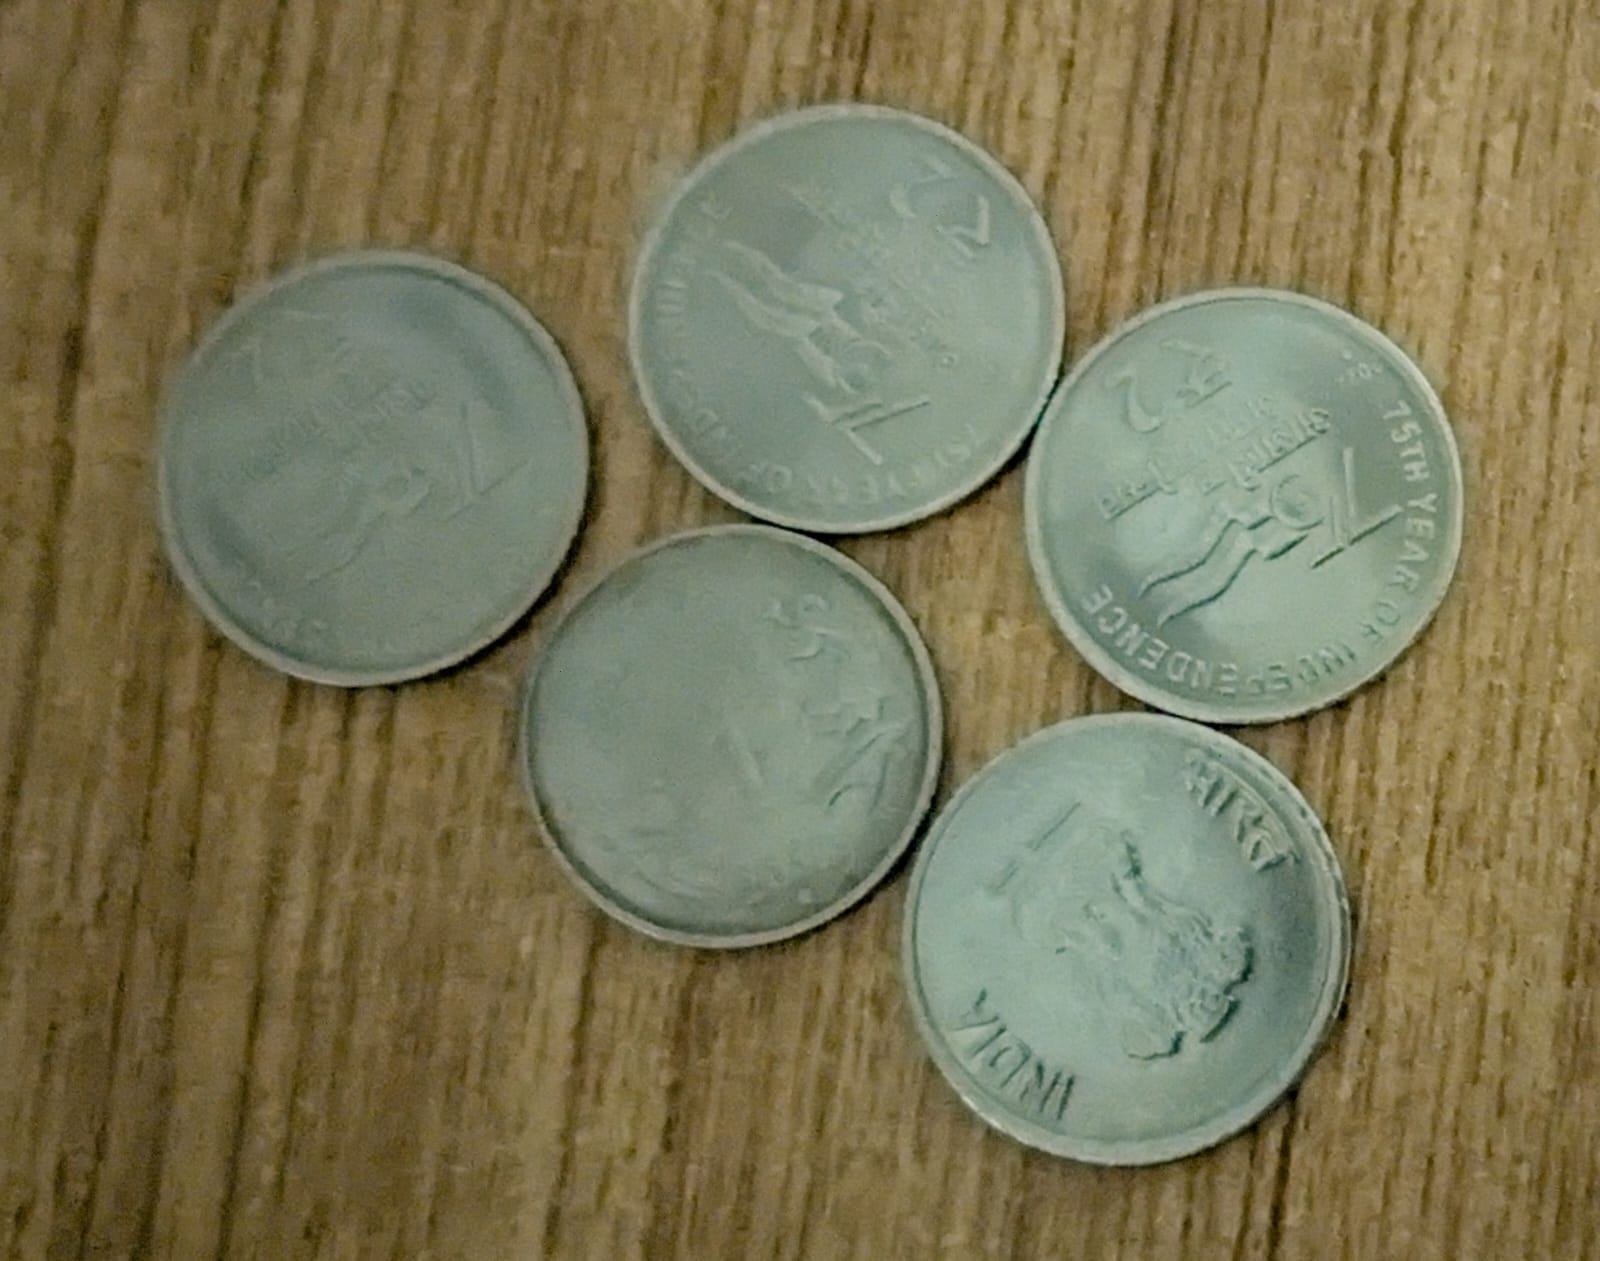

In [9]:
display(Image.fromarray(img))

In [11]:
lower_gray = np.array([0, 0, 30])   # Allow darker grays by lowering V
upper_gray = np.array([180, 70, 200])  # Slightly increase saturation range

# Create mask for gray pixels
gray_mask = cv2.inRange(hsv_img, lower_gray, upper_gray)

# Extract only gray regions from the original image
grayImage = cv2.bitwise_and(img, img, mask=gray_mask)

In [13]:
kernel = np.ones((3,3),np.uint8)
gray = cv2.cvtColor(grayImage, cv2.COLOR_BGR2GRAY)
blured = cv2.GaussianBlur(gray, (5,5),0)
ret, thresh = cv2.threshold(blured, 0, 255 , cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
edge_img = cv2.Canny(blured,100,200)
dilation = cv2.dilate(thresh,kernel,iterations = 1)

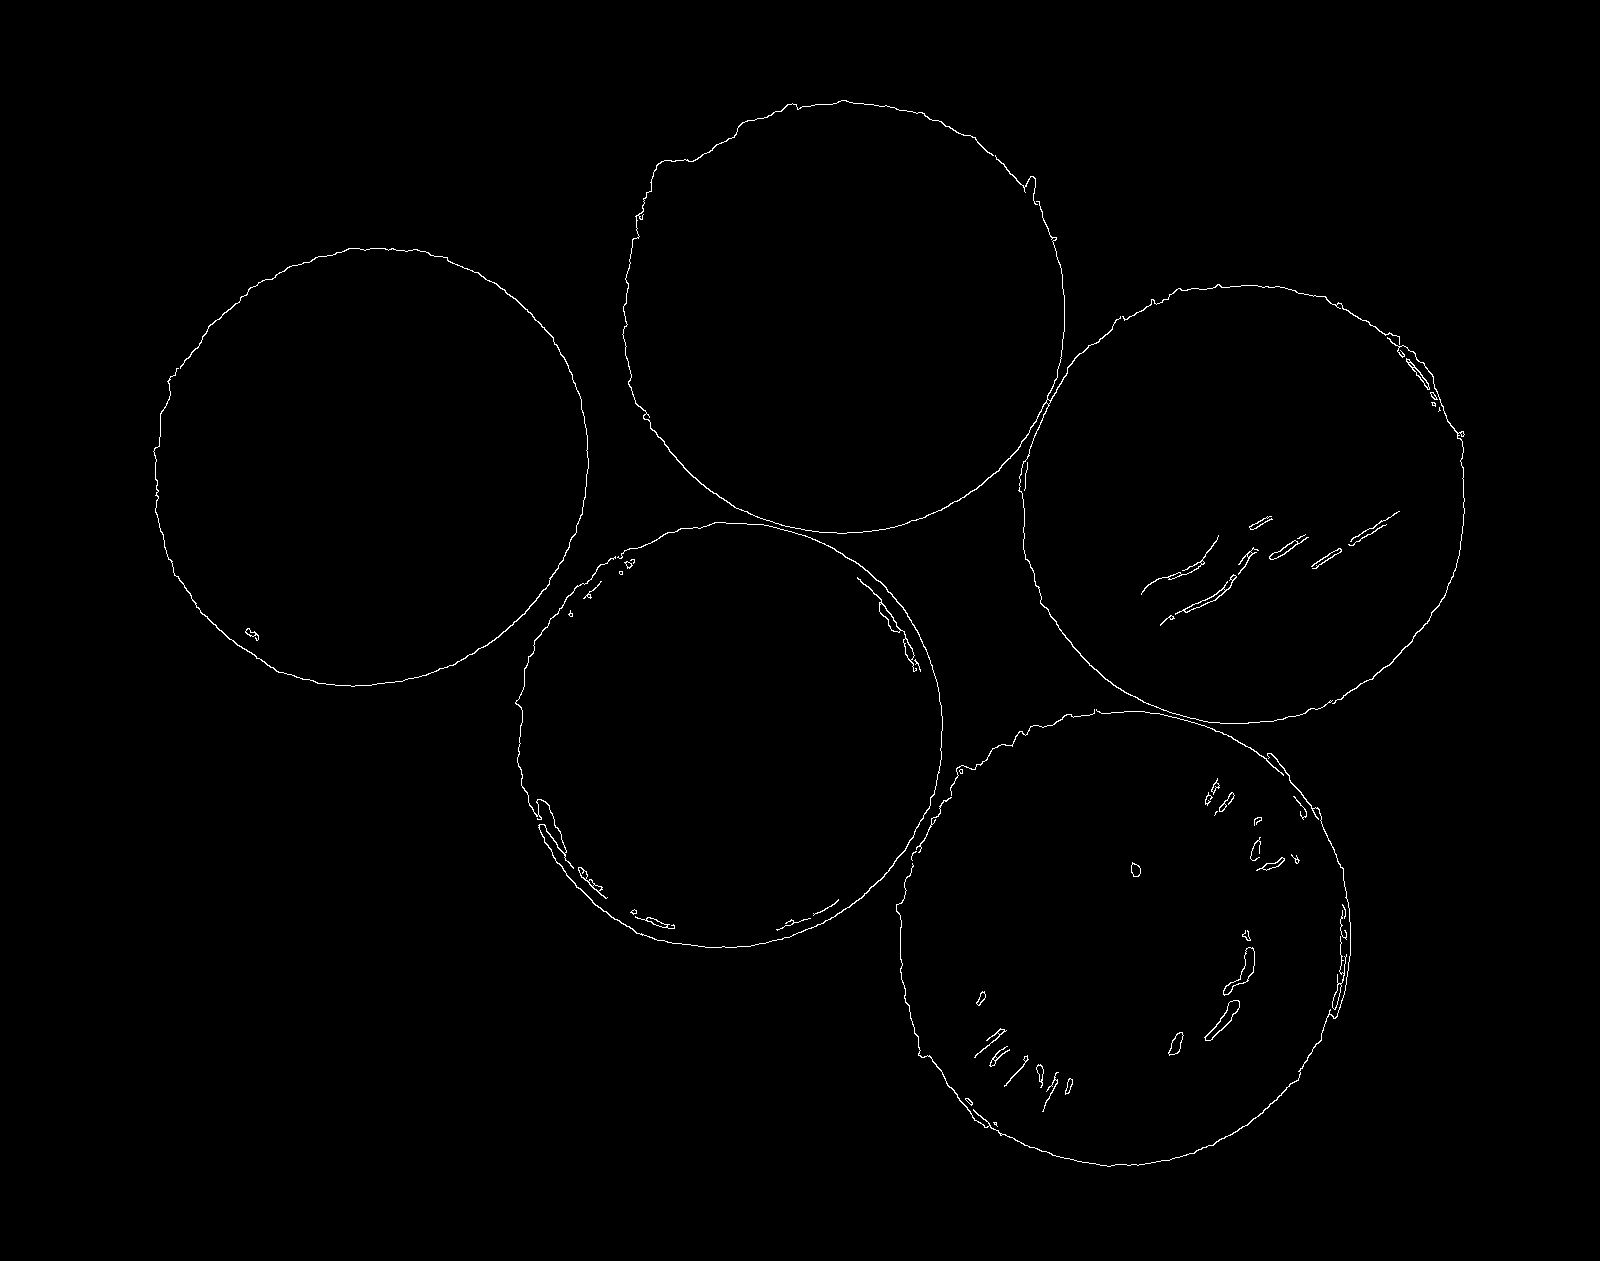

True

In [35]:
display(Image.fromarray(edge_img))
cv2.imwrite("output/detection.jpg", edge_img)

In [17]:
img2 = img.copy()
contours, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img2, contours, -1, (0, 255, 0), 2)

array([[[ 74,  61,  26],
        [ 73,  60,  25],
        [ 74,  61,  26],
        ...,
        [138, 117,  72],
        [143, 122,  79],
        [146, 125,  82]],

       [[ 79,  66,  31],
        [ 78,  65,  30],
        [ 78,  65,  30],
        ...,
        [140, 119,  74],
        [144, 123,  80],
        [147, 126,  83]],

       [[ 84,  71,  36],
        [ 84,  71,  36],
        [ 84,  71,  36],
        ...,
        [141, 120,  75],
        [145, 124,  81],
        [149, 128,  85]],

       ...,

       [[ 97,  79,  39],
        [ 96,  78,  38],
        [ 96,  79,  36],
        ...,
        [125, 105,  68],
        [120, 100,  63],
        [113,  93,  56]],

       [[ 98,  80,  40],
        [ 97,  79,  39],
        [ 96,  79,  36],
        ...,
        [125, 105,  68],
        [120, 100,  63],
        [114,  94,  57]],

       [[ 98,  81,  38],
        [ 97,  80,  37],
        [ 95,  78,  35],
        ...,
        [125, 105,  68],
        [120, 100,  63],
        [113,  93,  56]]

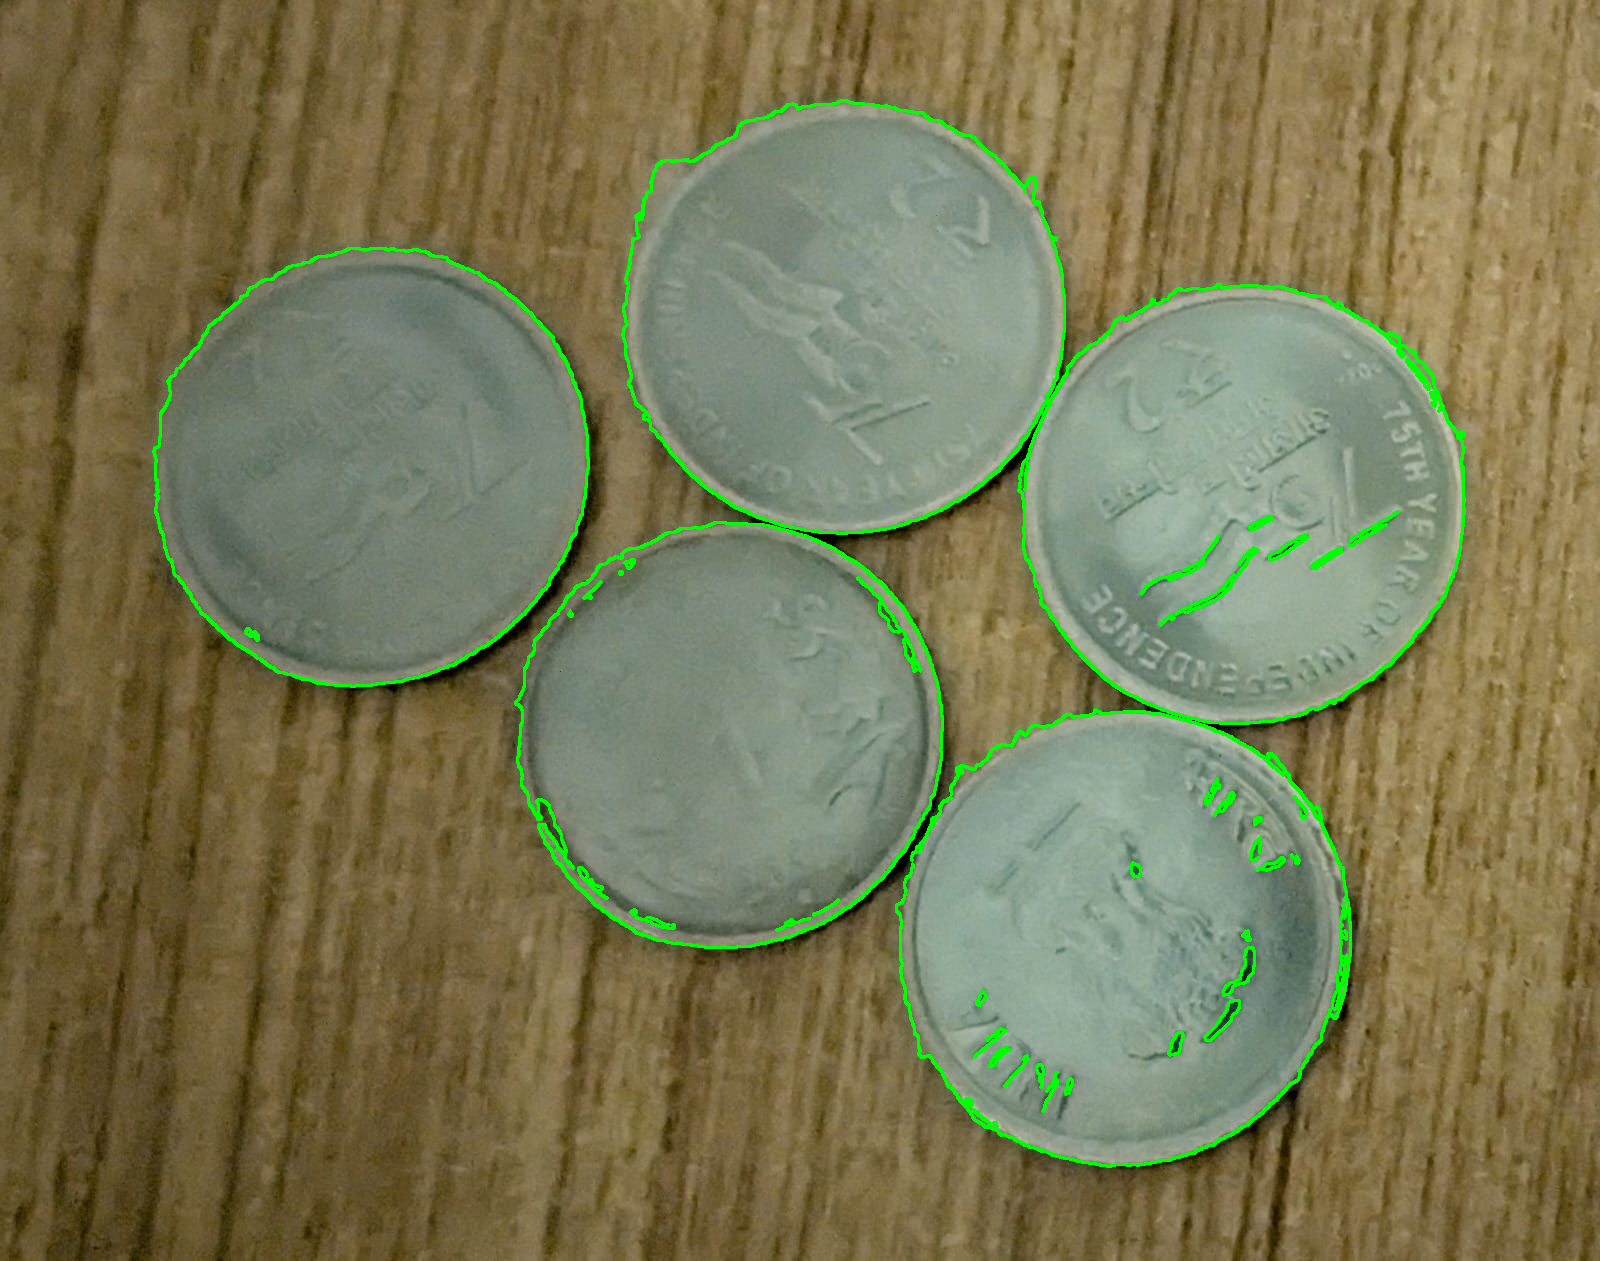

In [19]:
display(Image.fromarray(img2))
cv2.imwrite("output/segmented_coins.jpg", segmented_image)

In [21]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hierarchy = hierarchy[0]
max_area = cv2.contourArea(contours[0])
total = 0 # total contour size
for con in contours:
     area = cv2.contourArea(con) # get contour size
     total += area
     if area > max_area:
        max_area = area
diff = 0.1 # smallest contour have to bigger than (diff * max_area)
max_area = int(max_area * diff) # smallest contour have to bigger
average = int(total / (len(contours))) # average size for contour
radius_avg = int(math.sqrt(average / 3.14)) # average radius 

average = int(average * diff)

In [23]:
mask = np.zeros(dilation.shape[:2],dtype=np.uint8)
for component in zip(contours, hierarchy):
     currentContour = component[0]
     currentHierarchy = component[1]
     area = cv2.contourArea(currentContour)
     if currentHierarchy[3] < 0 and area > average:
          cv2.drawContours(mask, [currentContour], 0, (255), -1)


In [25]:
res1 = img.copy()
count = 0  # Result counter

for con in contours:
    area = cv2.contourArea(con)
    if area == 0:  # Avoid division by zero
        continue  

    radian = max(1, int(math.sqrt(area / 3.14)))  # Ensure radian > 0
    minRad = max(1, int(radian * 0.3))  # Avoid zero radius
    maxRad = max(minRad + 1, int(radian * 2))  # Ensure maxRad > minRad

    mask_temp = np.zeros(mask.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask_temp, [con], 0, 255, -1)

    circles = cv2.HoughCircles(
        mask_temp, cv2.HOUGH_GRADIENT, dp=1, minDist=max(10, 1.2 * radian),
        param1=100, param2=10, minRadius=minRad, maxRadius=maxRad
    )

    if circles is not None and len(circles) > 0:
        circles = np.uint16(np.around(circles))

        for i in circles[0, :]:
            radius = i[2]
            
            if radius > radius_avg:  # Ensure radius_avg is defined
                count += 1
                center = (i[0], i[1])  # Circle center
                cv2.putText(res1, str(count), center, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  
                cv2.circle(res1, center, radius, (0, 0, 255), 3) 

print('Number of objects:', count)

Number of objects: 5


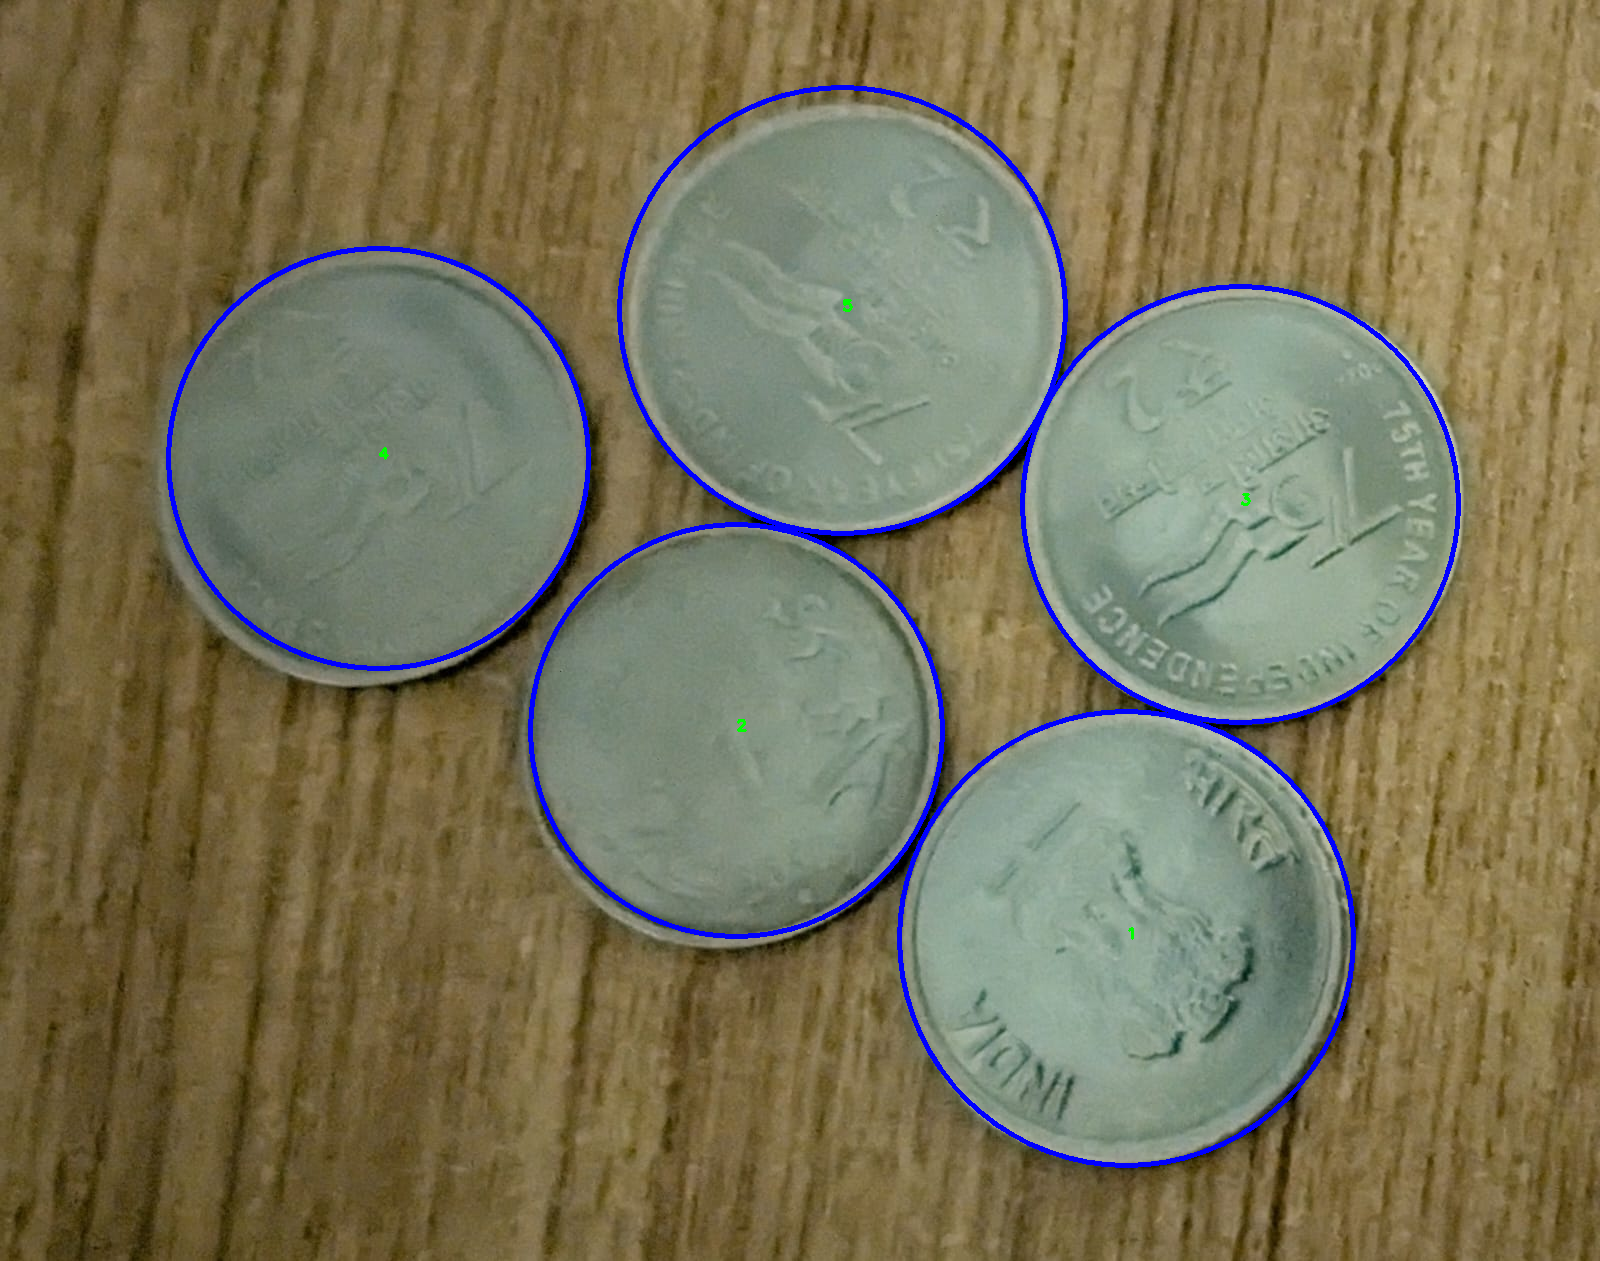

In [26]:
display(Image.fromarray(res1))